## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot_tools
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from library.utils import file_utils
from scipy.misc import toimage
%matplotlib inline

None


In [2]:
from sklearn import svm

In [3]:
total_time = 0
file_no = 5
exp_no = 102
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_svm_raw_cross_val/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

In [4]:
data_source = 'Website'
search_method = 'grid'
train_validate_split_data=None
one_hot=False

In [5]:
svm_max_iter = 10000
svm_cs = 500
exp_jobs = 10
num_images_required = 0.3
num_folds = 10

In [6]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
#  ]
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']},
    {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']},
]
param_name = 'exp_' + str(exp_no).zfill(3)

## Step 0: Load and visualize the CIFAR 10 dataset

In [7]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 15000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 1.9943 seconds
[ Step 0] Dataset loaded in 1994.961977 ms
Dataset size: (15000, 3072)


Plotting CIFAR 10 Train Dataset


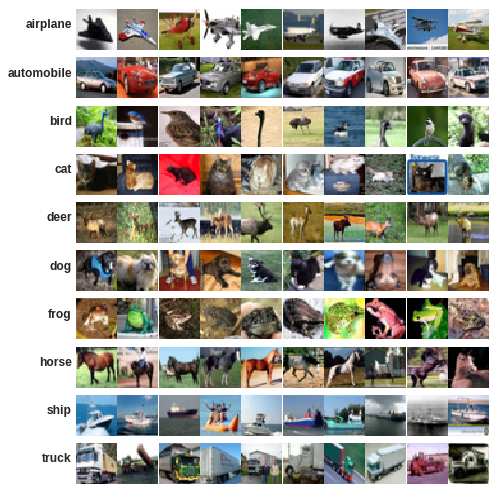

Plotting CIFAR 10 Test Dataset


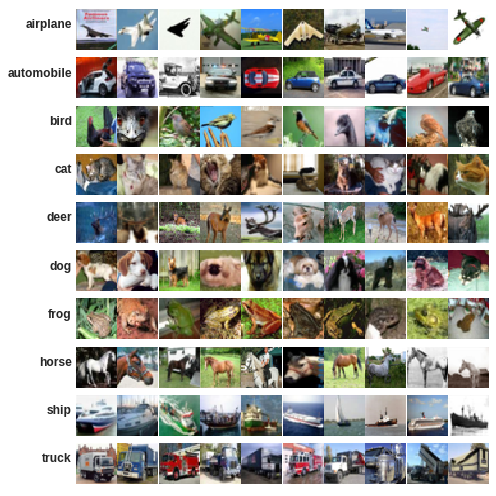

In [8]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

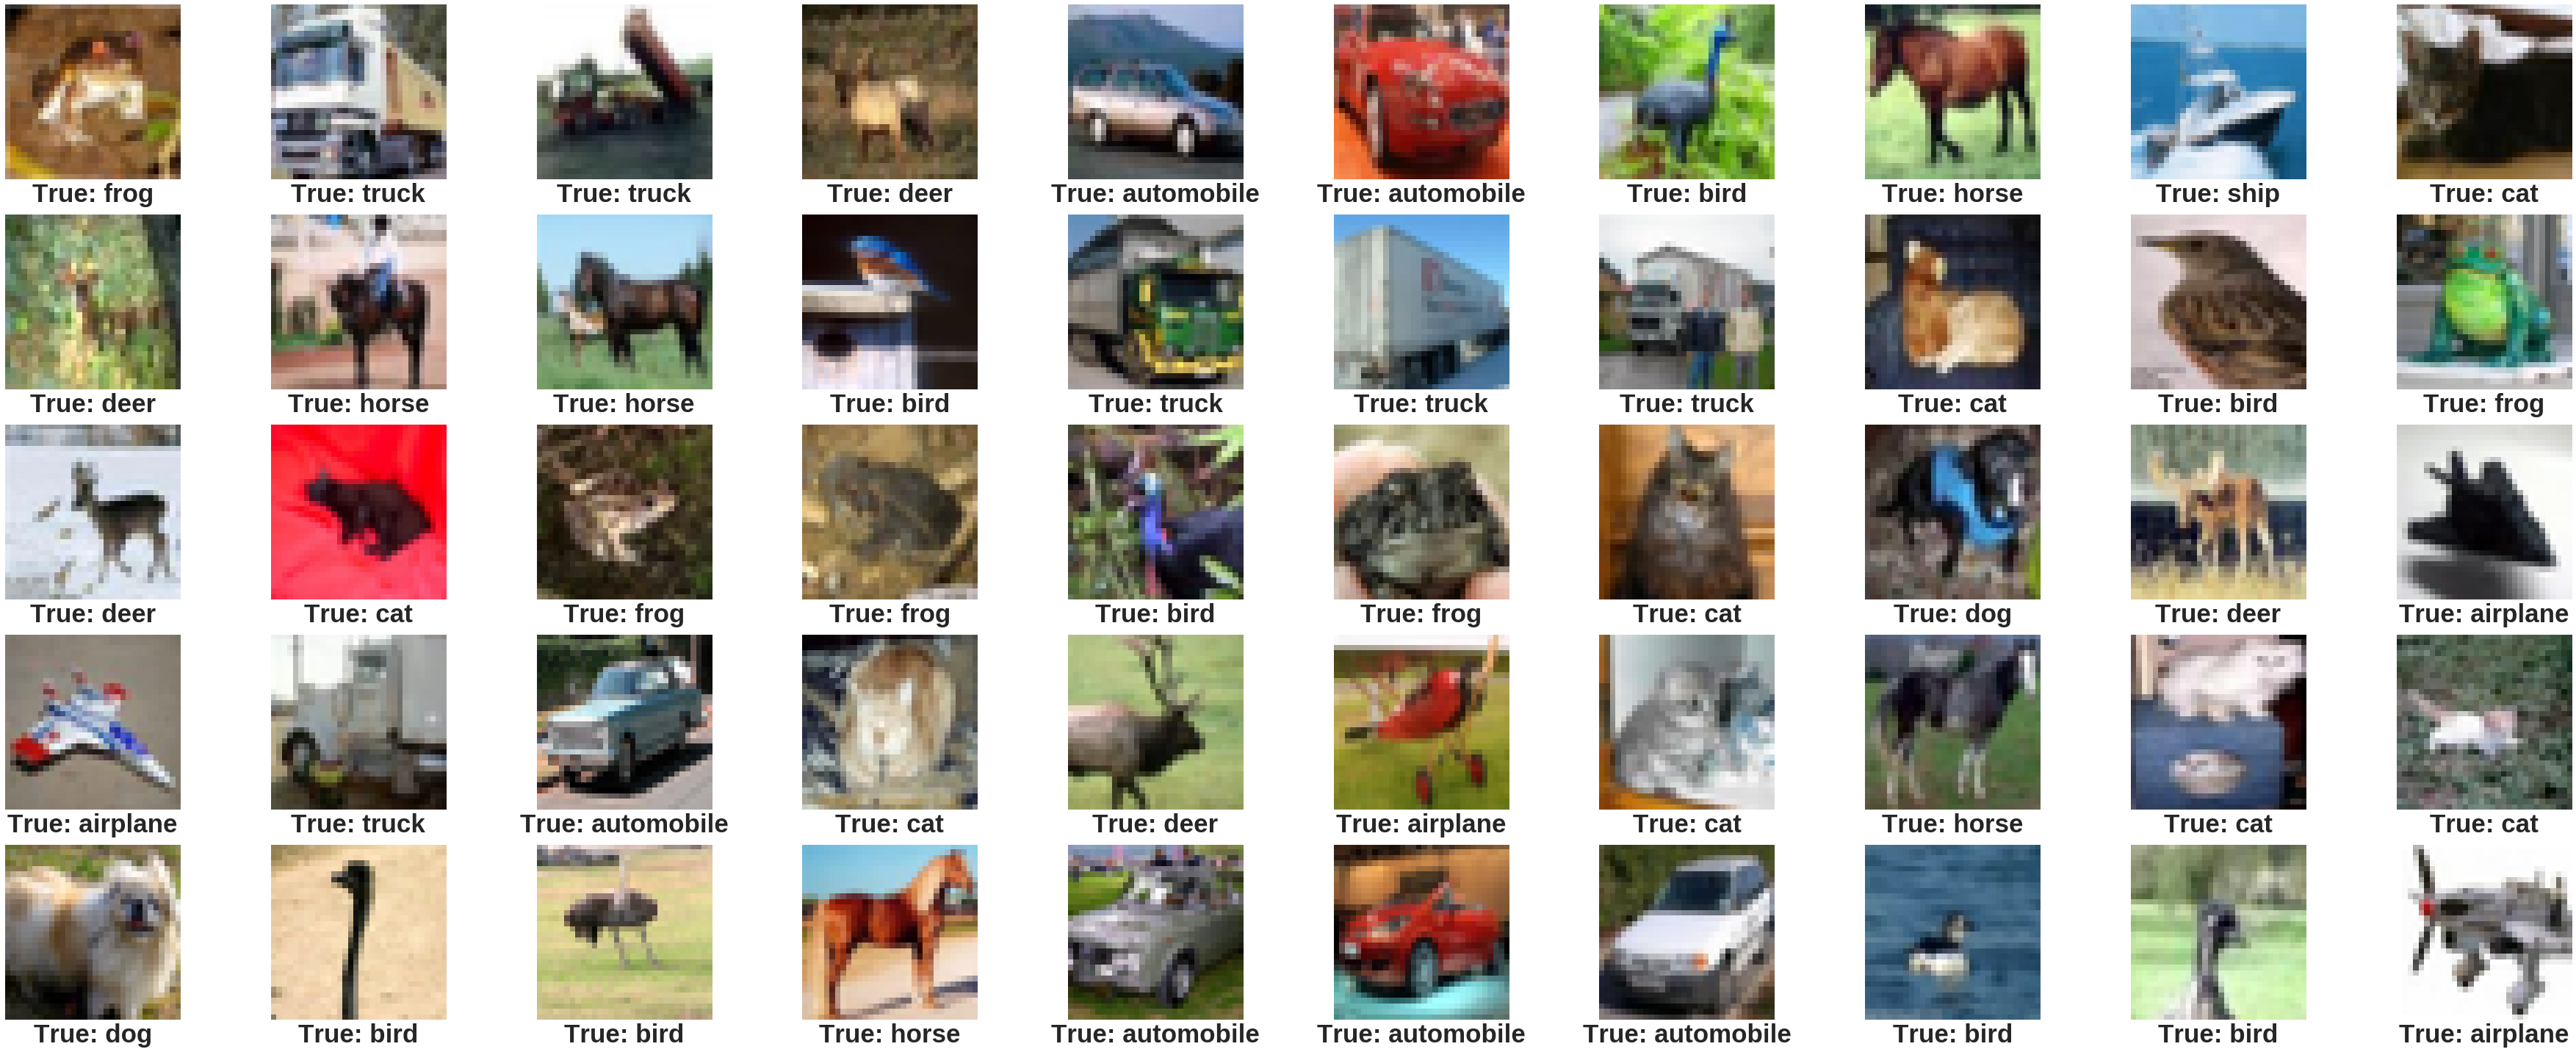

True

In [9]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

In [10]:
print('Training images')
print(cifar10.train.data[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])
print('[ Step 0.1] Working with only %d images' %num_train_images)

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing classes
[3 8 8 0 6]
[ Step 0.1] Working with only 15000 images


## Step 1: Preprocess data

In [11]:
start = time.time()
ss = StandardScaler()
data_images = ss.fit_transform(cifar10.train.data)
test_images = ss.fit_transform(cifar10.test.data)
end = time.time()
print('[ Step 1] Dataset transformations done in %5.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(cifar10.train.data.shape))
total_time += (end-start)

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[ Step 1] Dataset transformations done in 970.286846 ms
Training the classifier on 15000 images
Dataset size: (15000, 3072)


## Step 3: Parameters for estimatinng best model in SVM

In [12]:
print('Parameters to serach for')
print('\n'.join([str(param) for param in param_grid])); print()

Parameters to serach for
{'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
{'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']}
{'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']}



In [13]:
scores = []
scores_mean = []
scores_std = []

## Step 3.1: Run a search method for best parameters

In [14]:
svm_clf = svm.SVC(random_state=0, max_iter=svm_max_iter, cache_size=svm_cs, verbose=True)
print(svm_clf)

SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=True)


In [15]:
start = time.time()
if search_method == 'grid':
    print('Applying GridSearchCV')
    estimator = GridSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
elif search_method == 'random':
    print('Applying RandomizedSearchCV')
    estimator = RandomizedSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', n_iter=10, 
                              random_state=0, verbose=3, n_jobs=exp_jobs)
else:
    print('Applying GridSearchCV')
    estimator = GridSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
print(estimator)
estimator_result = estimator.fit(data_images, cifar10.train.class_labels)
end = time.time()
total_time += (end-start)
print('Total Time taken for cross validation and finding best parameters: %.4f ms' %((end-start)*1000))

Applying GridSearchCV
GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=True),
       fit_params={}, iid=True, n_jobs=10,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}, {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']}, {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ............

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 73.9min


[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.110220, total=24.5min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.112150, total=24.6min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.110220, total=24.6min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.107119, total=24.6min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.112957, total=24.7min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.105615, total=24.7min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.108594, total=24.7min
[CV] C=1, gamma=0.001

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 384.0min


[LibSVM][CV] ... C=100, gamma=0.001, kernel=rbf, score=0.487968, total=23.3min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[LibSVM][CV] ... C=100, gamma=0.001, kernel=rbf, score=0.486974, total=23.5min
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.475748, total=12.9min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.467110, total=12.9min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.472389, total=12.9min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.469646, total=13.0min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.487675, total=13.0min
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.453636, total=13.0min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.458250, total=12.9min
[CV] C=1000, gamma=0.

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.470432, total=12.8min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.471761, total=12.9min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.470393, total=12.8min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.487675, total=12.8min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.469646, total=13.0min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.450967, total=12.9min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.479973, total=12.9min
[CV] C=1, gamma=0.01,

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.387375, total=20.0min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.399202, total=19.0min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.411960, total=20.1min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.411059, total=20.0min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.405604, total=20.2min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.409486, total=20.1min
[CV] C=1, gamma=0.001, kernel=poly ...................................
[LibSVM][CV] ..... C=1, gamma=0.01, kernel=poly, score=0.387850, total=20.3min
[CV] C=1, gamma=0.001

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.411960, total=21.2min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.409847, total=21.0min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.423920, total=21.4min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.418388, total=21.3min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.403204, total=21.2min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.415610, total=21.5min
[CV] C=10, gamma=0.01, kernel=poly ...................................
[LibSVM][CV] .... C=1, gamma=0.001, kernel=poly, score=0.406146, total=21.3min
[CV] C=10, gamma=0.01

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.399202, total=19.2min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.387375, total=20.2min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.411059, total=20.1min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.411960, total=20.3min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.405604, total=20.4min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.387850, total=20.2min
[CV] C=10, gamma=0.001, kernel=poly ..................................
[LibSVM][CV] .... C=10, gamma=0.01, kernel=poly, score=0.400267, total=21.0min
[CV] C=10, gamma=0.00

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.418388, total=20.6min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.394544, total=19.7min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.392691, total=20.2min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.415947, total=20.8min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.406938, total=20.5min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.381175, total=20.5min
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[LibSVM][CV] ... C=10, gamma=0.001, kernel=poly, score=0.407605, total=21.1min
[CV] C=1, gamma=0.01,

[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 764.7min finished


[LibSVM]Total Time taken for cross validation and finding best parameters: 46511822.2082 ms


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [16]:
print('\n'.join('{}: {}'.format(k, v) for k, v in estimator.cv_results_.items())); print()
print('Scores for each set of parameters')
print('\n'.join([str(param) for param in estimator.grid_scores_])); print()
print('Best score')
print(estimator.best_score_); print()
print('Parameters corresponding to best score')
print(estimator.best_params_); print()

split0_test_score: [ 0.103  0.112  0.472  0.439  0.103  0.118  0.476  0.477  0.103  0.118  0.475  0.476  0.103  0.118  0.475  0.47   0.387  0.412  0.387  0.393  0.15   0.165  0.148  0.162]
split1_test_score: [ 0.103  0.113  0.494  0.454  0.103  0.116  0.503  0.506  0.103  0.116  0.502  0.467  0.103  0.116  0.502  0.472  0.412  0.424  0.412  0.416  0.142  0.169  0.146  0.17 ]
split2_test_score: [ 0.103  0.107  0.45   0.437  0.103  0.113  0.461  0.478  0.103  0.113  0.462  0.472  0.103  0.113  0.462  0.47   0.399  0.41   0.399  0.395  0.142  0.176  0.146  0.176]
split3_test_score: [ 0.103  0.109  0.478  0.458  0.103  0.108  0.49   0.516  0.103  0.108  0.491  0.488  0.103  0.108  0.491  0.488  0.411  0.418  0.411  0.418  0.142  0.164  0.141  0.157]
split4_test_score: [ 0.103  0.109  0.481  0.46   0.103  0.113  0.494  0.483  0.103  0.113  0.494  0.47   0.103  0.113  0.494  0.47   0.406  0.422  0.406  0.407  0.137  0.165  0.129  0.159]
split5_test_score: [ 0.103  0.11   0.47   0.448  0.103 

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## Step 3.1.1 Plot error lines showing +/- std. errors of the scores

In [17]:
means = estimator_result.cv_results_['mean_test_score']
stds = estimator_result.cv_results_['std_test_score']
params = estimator_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

0.102867 (0.000147) with: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.109800 (0.002135) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.473933 (0.011144) with: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.450333 (0.009830) with: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.102867 (0.000147) with: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.113267 (0.003298) with: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.482800 (0.012060) with: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.486733 (0.015247) with: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.102867 (0.000147) with: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.113267 (0.003298) with: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.482733 (0.011614) with: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.469067 (0.009437) with: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.102867 (0.000147) with: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.113267 (0.003298) with: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.482733 (0.011614) with: {'C': 1000, '

## Step 4: Save the generated model to file

In [18]:
start = time.time()
file_utils.mkdir_p(output_directory)
# model_output_path = model_output_directory + str(file_no).zfill(2) + '_' + 'svm_raw_features_cross_val_search_method_' \
#                     + search_method  + '_num_train_images_' + str(num_train_images) \
#                     + '_cache_size_' + str(svm_cs) + '_iter_' + str(svm_max_iter)  + '.pkl'
model_output_path = output_directory + '05_' + param_name + '.pkl'
joblib.dump(estimator, model_output_path)
end = time.time()
print('[ Step 4] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

[ Step 4] Write obtained model to ../logs/cifar10/05_svm_raw_cross_val/exp_no_102/05_exp_102.pkl in 5110.032082 ms


In [19]:
scores = []
exp = []
dict_key = ['train', 'test']
for key in dict_key:
    scores_list = []
    for i in range(num_folds):
        key_name = 'split' + str(i) + '_' + key + '_score'
        scores_list.append(estimator.cv_results_[key_name].tolist())
    scores.append(scores_list)
scores = np.array(scores)
means = np.mean(np.array(scores).T, axis=1)
stds = np.std(np.array(scores).T, axis=1)

In [20]:
plot_tools.plot_variance(scores, means, stds, legend=['Training data', 'Validation data'], 
                         plot_title=['Train scores for best parameters for SVC using raw pixels in CIFAR 10',
                                     'Validation scores for best parameters for SVC using raw pixels in CIFAR 10'], 
                         fig_size=(800,600), 
                         plot_xlabel=['SVC Parameters', 'SVC Parameters'],
                         plot_ylabel=['Training accuracy of the model', 'Validation accuracy of the model'],
                         plot_lib='bokeh', 
                         matplotlib_style='default', bokeh_notebook=True)

Loading BokehJS ...

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: Plot.background_fill was deprecated in Bokeh 0.11.0 and will be removed, use Plot.background_fill_color instead.
  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: Bo

## Step 5: Run the predictor on test data and generate predictions

In [21]:
start = time.time()
prediction_numbers = estimator.predict(test_images)
prediction_classes = []
num_test_images = test_images.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

[ Step 9] Make prediction on test dataset in 411213.283062 ms


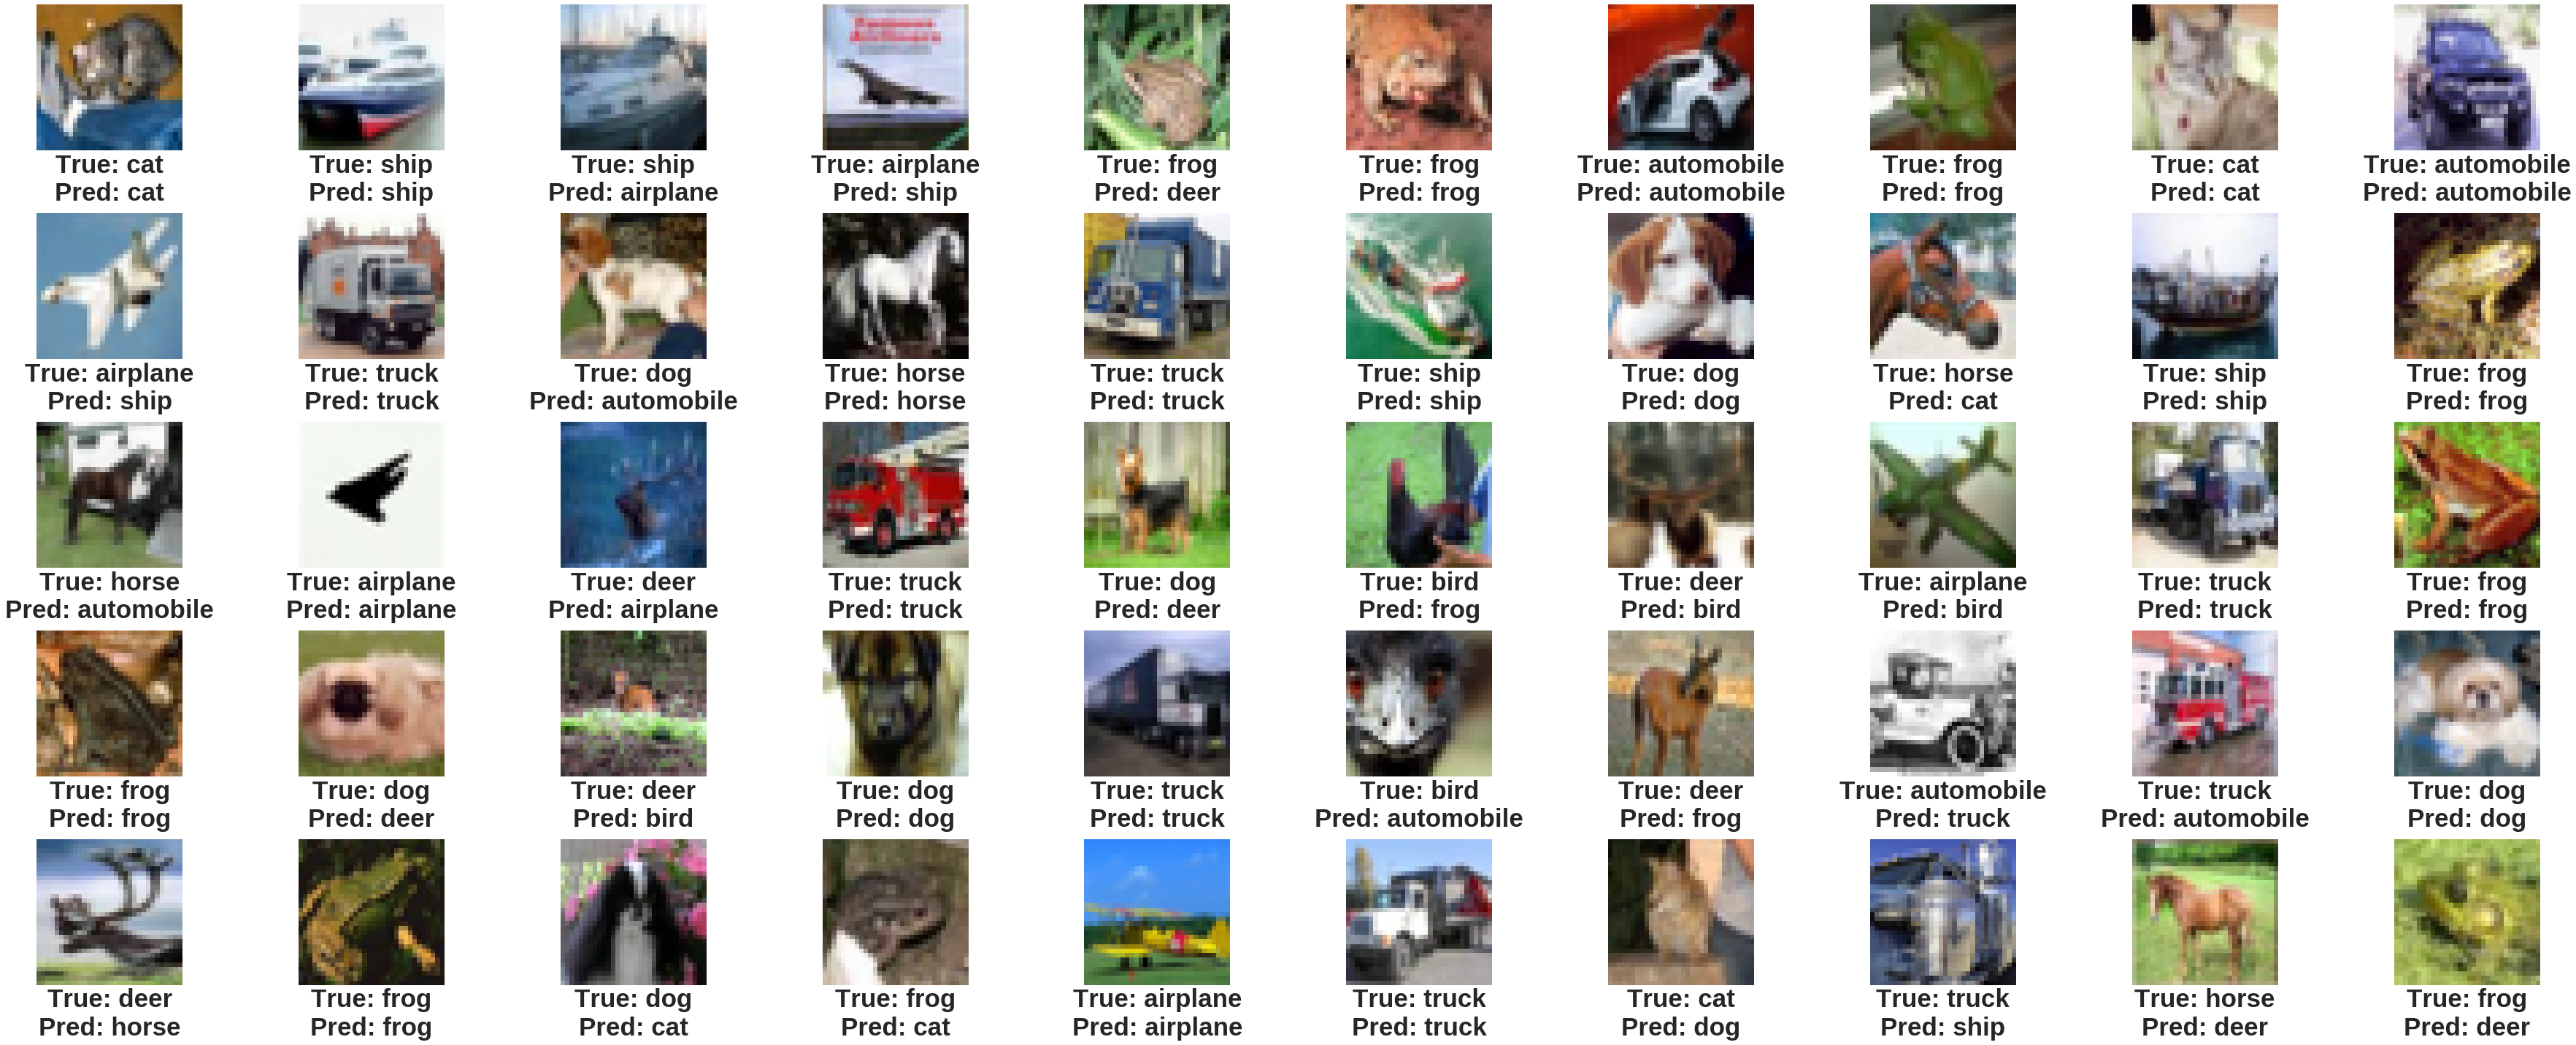

True

In [22]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 5.1 Print accuracy score of the classifier

Confusion matrix, without normalization
[[574  33  67  21  37  15  25  31 156  41]
 [ 60 607  21  36  17  20  20  27  55 137]
 [ 94  25 405  74 136  60 117  51  26  12]
 [ 31  30 106 371  75 148 117  50  29  43]
 [ 53  21 185  59 401  43 127  78  24   9]
 [ 27  19 117 193  89 352  94  62  26  21]
 [ 12  17 115 111 105  32 563  20  10  15]
 [ 47  29  58  70 101  73  36 512  23  51]
 [102  72  21  37  22  16  10  14 652  54]
 [ 52 181  17  29  14  18  39  45  78 527]]
Normalized confusion matrix
[[ 0.574  0.033  0.067  0.021  0.037  0.015  0.025  0.031  0.156  0.041]
 [ 0.06   0.607  0.021  0.036  0.017  0.02   0.02   0.027  0.055  0.137]
 [ 0.094  0.025  0.405  0.074  0.136  0.06   0.117  0.051  0.026  0.012]
 [ 0.031  0.03   0.106  0.371  0.075  0.148  0.117  0.05   0.029  0.043]
 [ 0.053  0.021  0.185  0.059  0.401  0.043  0.127  0.078  0.024  0.009]
 [ 0.027  0.019  0.117  0.193  0.089  0.352  0.094  0.062  0.026  0.021]
 [ 0.012  0.017  0.115  0.111  0.105  0.032  0.563  0.02   0.01

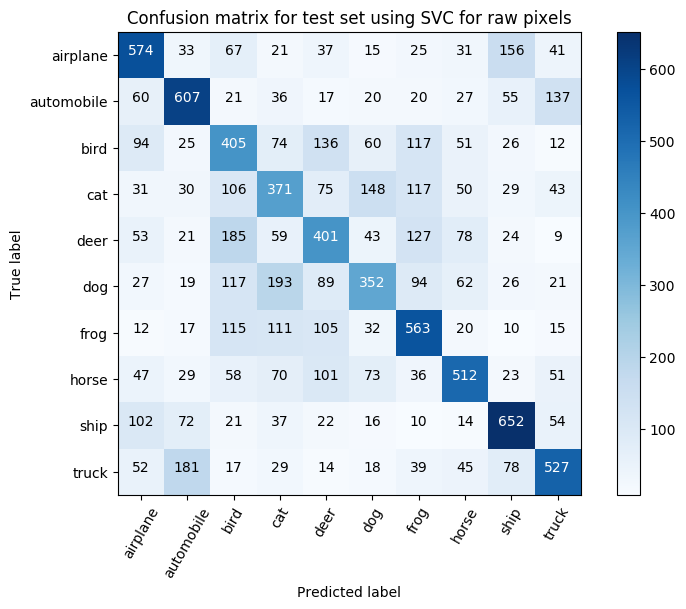

             precision    recall  f1-score   support

   airplane       0.55      0.57      0.56      1000
 automobile       0.59      0.61      0.60      1000
       bird       0.36      0.41      0.38      1000
        cat       0.37      0.37      0.37      1000
       deer       0.40      0.40      0.40      1000
        dog       0.45      0.35      0.40      1000
       frog       0.49      0.56      0.52      1000
      horse       0.58      0.51      0.54      1000
       ship       0.60      0.65      0.63      1000
      truck       0.58      0.53      0.55      1000

avg / total       0.50      0.50      0.50     10000

Accuracy score on test data: 0.4964


In [23]:
start = time.time()
plot_tools.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                              normalize=True, title='Confusion matrix for test set using SVC for raw pixels')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [24]:
start = time.time()
print('Prediction done on %d images' %cifar10.test.data.shape[0])
print('Accuracy of the classifier: %.4f' %estimator.score(test_images, cifar10.test.class_labels))
end = time.time()
total_time += (end-start)

Prediction done on 10000 images
Accuracy of the classifier: 0.4964


## Step 6: Write predictions to csv file

In [25]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
# output_csv_file = output_directory + str(file_no).zfill(2) + '_' + 'svm_raw_features_cross_val_search_method_' \
#                     + search_method  + '_num_train_images_' + str(num_train_images) \
#                     + '_cache_size_' + str(svm_cs) + '_iter_' + str(svm_max_iter)  + '.csv'
output_csv_file = output_directory + '05_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 6] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 6] Writing the test data to file: ../logs/cifar10/05_svm_raw_cross_val/exp_no_102/05_exp_102.csv in 492.370844 ms


## Step 7: Write the notebook to html file

In [26]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [27]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [30]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

Current file: ./05_CIFAR_10_SVM_Raw_Features_Cross_Validation.ipynb
Output file: ../logs/cifar10/05_svm_raw_cross_val/exp_no_102/05_exp_no_102_05_CIFAR_10_SVM_Raw_Features_Cross_Validation.html



In [32]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

Code took 47344.963610 s to run on training with 15000 examples
